# Cross-Tribal & Regional Fire Collaboration Analysis
## Building Networks for Collective Fire Resilience

**Fire doesn't respect political boundaries. Effective fire management requires collaboration across Tribal, federal, state, and local jurisdictions.**

**Why This Matters:**
- Fire spreads across reservation boundaries
- Shared ecosystems require coordinated management
- Resource sharing increases capacity
- Collective action amplifies political power
- Traditional territories often span multiple jurisdictions
- Climate change creates shared challenges

**Outputs:**
- Regional fire risk corridor maps
- Network graphs of connected Tribes
- Shared ecosystem analysis
- Collaboration opportunity rankings
- Resource sharing recommendations

## Imports

In [ ]:
# Install required packages (uncomment if needed) or install the tribal_fire.yaml from this repository
# !pip install geopandas pandas numpy matplotlib seaborn networkx shapely scipy folium

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, Normalize
import seaborn as sns
import networkx as nx
from shapely.geometry import Point, LineString, Polygon, box, MultiPolygon
from shapely.ops import unary_union, nearest_points
from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import warnings
from datetime import datetime
from pathlib import Path
import json
import folium
from folium import plugins

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

print("Libraries loaded successfully")
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print("\nBuilding networks for collective fire resilience")

Libraries loaded successfully
Analysis date: 2026-02-16 13:33

Building networks for collective fire resilience


## Load Data

### Load Tribal Lands

In [2]:
# Load multiple tribal reservations
# Real source: BIA AIAN Lands https://biamaps.doi.gov/

# Example: Create sample reservations across a region
sample_reservations = [
    {
        'tribe_id': 'TRIBE_001',
        'tribe_name': 'Warm Springs',
        'state': 'OR',
        'region': 'Pacific Northwest',
        'acres': 644000,
        'fire_program': True,
        'crew_size': 12,
        'lon': -121.3,
        'lat': 44.8
    },
    {
        'tribe_id': 'TRIBE_002',
        'tribe_name': 'Yakama',
        'state': 'WA',
        'region': 'Pacific Northwest',
        'acres': 1371000,
        'fire_program': True,
        'crew_size': 18,
        'lon': -120.8,
        'lat': 46.3
    },
    {
        'tribe_id': 'TRIBE_003',
        'tribe_name': 'Umatilla',
        'state': 'OR',
        'region': 'Pacific Northwest',
        'acres': 172000,
        'fire_program': True,
        'crew_size': 8,
        'lon': -118.6,
        'lat': 45.7
    },
    {
        'tribe_id': 'TRIBE_004',
        'tribe_name': 'Nez Perce',
        'state': 'ID',
        'region': 'Northern Rockies',
        'acres': 770000,
        'fire_program': True,
        'crew_size': 15,
        'lon': -116.2,
        'lat': 46.1
    },
    {
        'tribe_id': 'TRIBE_005',
        'tribe_name': 'Colville',
        'state': 'WA',
        'region': 'Pacific Northwest',
        'acres': 1400000,
        'fire_program': True,
        'crew_size': 20,
        'lon': -118.8,
        'lat': 48.2
    },
    {
        'tribe_id': 'TRIBE_006',
        'tribe_name': 'Flathead',
        'state': 'MT',
        'region': 'Northern Rockies',
        'acres': 1244000,
        'fire_program': True,
        'crew_size': 14,
        'lon': -114.2,
        'lat': 47.8
    },
    {
        'tribe_id': 'TRIBE_007',
        'tribe_name': 'Klamath',
        'state': 'OR',
        'region': 'Pacific Northwest',
        'acres': 1000,  # Lost most land
        'fire_program': False,
        'crew_size': 0,
        'lon': -122.0,
        'lat': 42.5
    },
    {
        'tribe_id': 'TRIBE_008',
        'tribe_name': 'Spokane',
        'state': 'WA',
        'region': 'Pacific Northwest',
        'acres': 159000,
        'fire_program': True,
        'crew_size': 6,
        'lon': -117.8,
        'lat': 47.9
    }
]

# Create geometries (simplified circles for demonstration)
tribal_lands = []
for res in sample_reservations:
    # Size based on acreage
    radius = np.sqrt(res['acres'] / 100000) * 0.2
    geom = Point(res['lon'], res['lat']).buffer(radius)
    
    tribal_lands.append({
        **res,
        'geometry': geom
    })

tribal_lands = gpd.GeoDataFrame(tribal_lands, crs='EPSG:4326')

print(f"Loaded {len(tribal_lands)} tribal reservations")
print(f"\nBy region:")
print(tribal_lands['region'].value_counts())
print(f"\nWith fire programs: {tribal_lands['fire_program'].sum()}")
print(f"Total crew capacity: {tribal_lands['crew_size'].sum()} personnel")

display(tribal_lands[['tribe_name', 'state', 'region', 'acres', 'fire_program', 'crew_size']])

Loaded 8 tribal reservations

By region:
region
Pacific Northwest    6
Northern Rockies     2
Name: count, dtype: int64

With fire programs: 7
Total crew capacity: 93 personnel


,tribe_name,state,region,acres,fire_program,crew_size
0,Warm Springs,OR,Pacific Northwest,644000,True,12
1,Yakama,WA,Pacific Northwest,1371000,True,18
2,Umatilla,OR,Pacific Northwest,172000,True,8
3,Nez Perce,ID,Northern Rockies,770000,True,15
4,Colville,WA,Pacific Northwest,1400000,True,20
5,Flathead,MT,Northern Rockies,1244000,True,14
6,Klamath,OR,Pacific Northwest,1000,False,0
7,Spokane,WA,Pacific Northwest,159000,True,6


### Load/Generate Fire Risk Data

In [ ]:
def generate_regional_fire_risk(tribal_lands_gdf, buffer_km=50, grid_size_km=10):
       
    # Work in projected CRS
    tribal_lands_projected = tribal_lands_gdf.to_crs('EPSG:5070')
    
    # Create risk zones as buffers
    print("Creating risk zones...")
    
    # Multiple buffer zones for different risk levels
    buffer_5km = tribal_lands_projected.geometry.buffer(5000).unary_union
    buffer_15km = tribal_lands_projected.geometry.buffer(15000).unary_union
    buffer_30km = tribal_lands_projected.geometry.buffer(30000).unary_union
    buffer_50km = tribal_lands_projected.geometry.buffer(50000).unary_union
    
    # Create grid
    bounds = tribal_lands_projected.total_bounds
    buffer_m = buffer_km * 1000
    xmin, ymin, xmax, ymax = bounds
    xmin -= buffer_m
    ymin -= buffer_m
    xmax += buffer_m
    ymax += buffer_m
    
    grid_size_m = grid_size_km * 1000
    
    print(f"Generating grid...")
    risk_cells = []
    
    x_coords = np.arange(xmin, xmax, grid_size_m)
    y_coords = np.arange(ymin, ymax, grid_size_m)
    
    for x in x_coords:
        for y in y_coords:
            cell = box(x, y, x + grid_size_m, y + grid_size_m)
            centroid = cell.centroid
            
            # Check which buffer zone the centroid falls in
            if buffer_5km.contains(centroid):
                base_risk = 0.6
            elif buffer_15km.contains(centroid):
                base_risk = 0.8
            elif buffer_30km.contains(centroid):
                base_risk = 0.5
            elif buffer_50km.contains(centroid):
                base_risk = 0.3
            else:
                continue  # Skip cells outside all buffers
            
            # Add variation
            risk_score = base_risk + np.random.uniform(-0.2, 0.2)
            risk_score = np.clip(risk_score, 0, 1)
            
            risk_cells.append({
                'risk_score': risk_score,
                'risk_category': 'High' if risk_score > 0.7 else 'Moderate' if risk_score > 0.4 else 'Low',
                'geometry': cell
            })
    
    print(f"Created {len(risk_cells)} risk cells")
    
    # Create GeoDataFrame and convert back to WGS84
    risk_gdf = gpd.GeoDataFrame(risk_cells, crs='EPSG:5070')
    risk_gdf = risk_gdf.to_crs('EPSG:4326')
    
    return risk_gdf


# Generate fire risk
fire_risk = generate_regional_fire_risk(tribal_lands, buffer_km=50, grid_size_km=10)

 
print("\nREGIONAL FIRE RISK DATA")
print("="*80)
print(f"Total cells: {len(fire_risk)}")
print("\nRisk distribution:")
print(fire_risk['risk_category'].value_counts())
print(f"\nMean risk score: {fire_risk['risk_score'].mean():.2f}")

Creating risk zones...
Generating grid...
Created 2188 risk cells

REGIONAL FIRE RISK DATA
Creating risk zones...
Generating grid...
Created 2188 risk cells

REGIONAL FIRE RISK DATA
Total cells: 2188

Risk distribution:
risk_category
Moderate    1144
Low          675
High         369
Name: count, dtype: int64

Mean risk score: 0.50


### Load or Generate Ecosystem and Watershed Data

In [6]:
def generate_watersheds(tribal_lands_gdf):
    """
    Generate watershed boundaries.
    
    Real data sources:
    - USGS Watershed Boundary Dataset (WBD)
    - HUC-8 or HUC-10 watersheds
    """
    bounds = tribal_lands_gdf.total_bounds
    
    watersheds = [
        {
            'watershed_id': 'WS_001',
            'name': 'Columbia River Basin - Upper',
            'huc8': '17070101',
            'area_sqkm': 12500,
            'geometry': box(bounds[0], bounds[1] + 0.5, bounds[2] - 1, bounds[3])
        },
        {
            'watershed_id': 'WS_002',
            'name': 'Columbia River Basin - Middle',
            'huc8': '17070102',
            'area_sqkm': 15000,
            'geometry': box(bounds[0] + 0.5, bounds[1], bounds[2] - 0.5, bounds[3] - 1)
        },
        {
            'watershed_id': 'WS_003',
            'name': 'Snake River Basin',
            'huc8': '17060201',
            'area_sqkm': 18000,
            'geometry': box(bounds[2] - 2, bounds[1], bounds[2], bounds[3] - 0.5)
        },
        {
            'watershed_id': 'WS_004',
            'name': 'Klamath River Basin',
            'huc8': '18010201',
            'area_sqkm': 8500,
            'geometry': box(bounds[0], bounds[1], bounds[0] + 1.5, bounds[1] + 1)
        }
    ]
    
    return gpd.GeoDataFrame(watersheds, crs='EPSG:4326')

def generate_ecosystems(tribal_lands_gdf):
    """
    Generate ecosystem regions.
    
    Real data sources:
    - EPA Ecoregions (Level III or IV)
    - USFS Ecological Subsections
    - LANDFIRE Biophysical Settings
    """
    bounds = tribal_lands_gdf.total_bounds
    
    ecosystems = [
        {
            'ecosystem_id': 'ECO_001',
            'name': 'Blue Mountains',
            'type': 'Mixed Conifer Forest',
            'fire_regime': 'Frequent Low-Moderate Severity',
            'geometry': box(bounds[0] + 1, bounds[1], bounds[2] - 1, bounds[3] - 1)
        },
        {
            'ecosystem_id': 'ECO_002',
            'name': 'Cascade Mountains',
            'type': 'Dry Forest',
            'fire_regime': 'Mixed Severity',
            'geometry': box(bounds[0], bounds[1] + 0.5, bounds[0] + 2, bounds[3])
        },
        {
            'ecosystem_id': 'ECO_003',
            'name': 'Northern Rockies',
            'type': 'Subalpine Forest',
            'fire_regime': 'Infrequent High Severity',
            'geometry': box(bounds[2] - 2, bounds[1] + 1, bounds[2], bounds[3])
        },
        {
            'ecosystem_id': 'ECO_004',
            'name': 'Columbia Plateau',
            'type': 'Shrubland-Grassland',
            'fire_regime': 'Frequent Low Severity',
            'geometry': box(bounds[0] + 0.5, bounds[1], bounds[2] - 1.5, bounds[1] + 1.5)
        }
    ]
    
    return gpd.GeoDataFrame(ecosystems, crs='EPSG:4326')

# Generate watersheds and ecosystems
watersheds = generate_watersheds(tribal_lands)
ecosystems = generate_ecosystems(tribal_lands)

print("\nWATERSHEDS & ECOSYSTEMS")
print("="*80)
print(f"\nWatersheds: {len(watersheds)}")
display(watersheds[['name', 'huc8', 'area_sqkm']])

print(f"\nEcosystems: {len(ecosystems)}")
display(ecosystems[['name', 'type', 'fire_regime']])


WATERSHEDS & ECOSYSTEMS

Watersheds: 4


,name,huc8,area_sqkm
0,Columbia River Basin - Upper,17070101,12500
1,Columbia River Basin - Middle,17070102,15000
2,Snake River Basin,17060201,18000
3,Klamath River Basin,18010201,8500



Ecosystems: 4


,name,type,fire_regime
0,Blue Mountains,Mixed Conifer Forest,Frequent Low-Moderate Severity
1,Cascade Mountains,Dry Forest,Mixed Severity
2,Northern Rockies,Subalpine Forest,Infrequent High Severity
3,Columbia Plateau,Shrubland-Grassland,Frequent Low Severity


## Fire Risk Corridor Analysis

### Identify Inter-Tribal Fire Corridors

In [7]:
def identify_fire_corridors(tribal_lands_gdf, fire_risk_gdf, risk_threshold=7):
    """
    Identify high-risk corridors connecting multiple Tribal lands.
    
    A corridor is defined as:
    - High fire risk area (score >= threshold)
    - Connects or lies between multiple reservations
    - Could facilitate fire spread across boundaries
    """
    # Get high-risk areas
    high_risk = fire_risk_gdf[fire_risk_gdf['risk_score'] >= risk_threshold].copy()
    
    # Convert to metric CRS for distance calculations
    tribal_metric = tribal_lands_gdf.to_crs('EPSG:5070')
    high_risk_metric = high_risk.to_crs('EPSG:5070')
    
    corridors = []
    
    # For each high-risk cell, find which tribes it connects
    for idx, risk_cell in high_risk_metric.iterrows():
        # Find tribes within 20km
        buffer = risk_cell.geometry.buffer(20000)  # 20km
        
        connected_tribes = tribal_metric[
            tribal_metric.intersects(buffer) | 
            tribal_metric.geometry.distance(risk_cell.geometry) < 20000
        ]
        
        if len(connected_tribes) >= 2:
            # This cell is part of a corridor connecting multiple tribes
            tribe_list = connected_tribes['tribe_name'].tolist()
            tribe_ids = connected_tribes['tribe_id'].tolist()
            
            corridors.append({
                'corridor_id': f"CORRIDOR_{idx:04d}",
                'risk_score': high_risk.loc[idx, 'risk_score'],
                'connected_tribes': ', '.join(tribe_list),
                'tribe_ids': tribe_ids,
                'num_tribes': len(connected_tribes),
                'geometry': high_risk.loc[idx, 'geometry']
            })
    
    if len(corridors) == 0:
        return gpd.GeoDataFrame()
    
    corridors_gdf = gpd.GeoDataFrame(corridors, crs='EPSG:4326')
    
    # Merge adjacent corridor cells
    corridors_gdf = corridors_gdf.dissolve(
        by='connected_tribes',
        aggfunc={
            'risk_score': 'mean',
            'num_tribes': 'first',
            'tribe_ids': 'first'
        }
    ).reset_index()
    
    corridors_gdf['corridor_area_sqkm'] = corridors_gdf.to_crs('EPSG:5070').area / 1e6
    
    return corridors_gdf

# Identify fire corridors
fire_corridors = identify_fire_corridors(tribal_lands, fire_risk)

print("\nINTER-TRIBAL FIRE RISK CORRIDORS")
print("="*80)
print(f"Corridors identified: {len(fire_corridors)}")

if len(fire_corridors) > 0:
    print(f"Total corridor area: {fire_corridors['corridor_area_sqkm'].sum():,.0f} km²")
    print(f"Mean risk score: {fire_corridors['risk_score'].mean():.2f}")
    print("\nTop corridors by area:")
    display(fire_corridors.nlargest(5, 'corridor_area_sqkm')[[
        'connected_tribes', 'num_tribes', 'corridor_area_sqkm', 'risk_score'
    ]].round(2))
else:
    print("No multi-tribal corridors identified with current thresholds")


INTER-TRIBAL FIRE RISK CORRIDORS
Corridors identified: 0
No multi-tribal corridors identified with current thresholds


### Analyze Shared Watersheds

In [8]:
def analyze_shared_watersheds(tribal_lands_gdf, watersheds_gdf):
    """
    Identify watersheds shared by multiple Tribes.
    """
    shared_watersheds = []
    
    for idx, watershed in watersheds_gdf.iterrows():
        # Find tribes that intersect this watershed
        tribes_in_watershed = tribal_lands_gdf[
            tribal_lands_gdf.intersects(watershed.geometry)
        ]
        
        if len(tribes_in_watershed) >= 2:
            # Calculate area of each tribe within watershed
            tribe_areas = []
            for _, tribe in tribes_in_watershed.iterrows():
                intersection = tribe.geometry.intersection(watershed.geometry)
                area_sqkm = gpd.GeoSeries([intersection], crs='EPSG:4326').to_crs(
                    'EPSG:5070'
                ).area.iloc[0] / 1e6
                tribe_areas.append(area_sqkm)
            
            shared_watersheds.append({
                'watershed_id': watershed['watershed_id'],
                'watershed_name': watershed['name'],
                'num_tribes': len(tribes_in_watershed),
                'tribe_names': tribes_in_watershed['tribe_name'].tolist(),
                'tribe_ids': tribes_in_watershed['tribe_id'].tolist(),
                'total_tribal_area_sqkm': sum(tribe_areas),
                'pct_of_watershed': sum(tribe_areas) / watershed['area_sqkm'] * 100,
                'geometry': watershed.geometry
            })
    
    if len(shared_watersheds) == 0:
        return pd.DataFrame()
    
    return pd.DataFrame(shared_watersheds)

# Analyze shared watersheds
shared_watersheds = analyze_shared_watersheds(tribal_lands, watersheds)

print("\nSHARED WATERSHED ANALYSIS")
print("="*80)
print(f"Watersheds shared by multiple tribes: {len(shared_watersheds)}")

if len(shared_watersheds) > 0:
    for idx, ws in shared_watersheds.iterrows():
        print(f"\n{ws['watershed_name']}:")
        print(f"  Tribes: {', '.join(ws['tribe_names'])}")
        print(f"  Tribal lands: {ws['total_tribal_area_sqkm']:.0f} km² ({ws['pct_of_watershed']:.1f}% of watershed)")


SHARED WATERSHED ANALYSIS
Watersheds shared by multiple tribes: 2

Columbia River Basin - Upper:
  Tribes: Warm Springs, Yakama, Umatilla, Nez Perce, Colville, Flathead, Spokane
  Tribal lands: 51326 km² (410.6% of watershed)

Columbia River Basin - Middle:
  Tribes: Warm Springs, Yakama, Umatilla, Nez Perce, Colville, Flathead, Spokane
  Tribal lands: 41189 km² (274.6% of watershed)


### Analyze Shared Ecosystems

In [9]:
def analyze_shared_ecosystems(tribal_lands_gdf, ecosystems_gdf):
    """
    Identify ecosystems shared by multiple Tribes.
    Tribes in same ecosystem can share fire management knowledge.
    """
    shared_ecosystems = []
    
    for idx, ecosystem in ecosystems_gdf.iterrows():
        # Find tribes that intersect this ecosystem
        tribes_in_ecosystem = tribal_lands_gdf[
            tribal_lands_gdf.intersects(ecosystem.geometry)
        ]
        
        if len(tribes_in_ecosystem) >= 1:  # Include single-tribe for comparison
            shared_ecosystems.append({
                'ecosystem_id': ecosystem['ecosystem_id'],
                'ecosystem_name': ecosystem['name'],
                'ecosystem_type': ecosystem['type'],
                'fire_regime': ecosystem['fire_regime'],
                'num_tribes': len(tribes_in_ecosystem),
                'tribe_names': tribes_in_ecosystem['tribe_name'].tolist(),
                'tribe_ids': tribes_in_ecosystem['tribe_id'].tolist(),
                'geometry': ecosystem.geometry
            })
    
    if len(shared_ecosystems) == 0:
        return pd.DataFrame()
    
    return pd.DataFrame(shared_ecosystems)

# Analyze shared ecosystems
shared_ecosystems = analyze_shared_ecosystems(tribal_lands, ecosystems)

print("\nSHARED ECOSYSTEM ANALYSIS")
print("="*80)
print(f"Total ecosystems: {len(shared_ecosystems)}")
print(f"Multi-tribal ecosystems: {len(shared_ecosystems[shared_ecosystems['num_tribes'] >= 2])}")

if len(shared_ecosystems) > 0:
    for idx, eco in shared_ecosystems.iterrows():
        if eco['num_tribes'] >= 2:
            print(f"\n{eco['ecosystem_name']} ({eco['ecosystem_type']}):")
            print(f"  Fire Regime: {eco['fire_regime']}")
            print(f"  Tribes: {', '.join(eco['tribe_names'])}")
            print(f"  Knowledge sharing opportunity for {eco['fire_regime']} management")


SHARED ECOSYSTEM ANALYSIS
Total ecosystems: 3
Multi-tribal ecosystems: 2

Blue Mountains (Mixed Conifer Forest):
  Fire Regime: Frequent Low-Moderate Severity
  Tribes: Warm Springs, Yakama, Umatilla, Nez Perce, Colville, Flathead, Spokane
  Knowledge sharing opportunity for Frequent Low-Moderate Severity management

Cascade Mountains (Dry Forest):
  Fire Regime: Mixed Severity
  Tribes: Warm Springs, Yakama
  Knowledge sharing opportunity for Mixed Severity management


## Network Analysis

### Build Tribal Collaboration Network

In [10]:
def build_collaboration_network(tribal_lands_gdf, corridors_gdf, 
                               shared_watersheds_df, shared_ecosystems_df):
    """
    Build network graph of tribal collaboration opportunities.
    
    Connections based on:
    1. Shared fire risk corridors
    2. Shared watersheds
    3. Shared ecosystems/fire regimes
    4. Geographic proximity
    """
    G = nx.Graph()
    
    # Add nodes for each tribe
    for idx, tribe in tribal_lands_gdf.iterrows():
        G.add_node(
            tribe['tribe_id'],
            name=tribe['tribe_name'],
            state=tribe['state'],
            region=tribe['region'],
            acres=tribe['acres'],
            fire_program=tribe['fire_program'],
            crew_size=tribe['crew_size'],
            lat=tribe['lat'],
            lon=tribe['lon']
        )
    
    # Add edges based on shared corridors
    if len(corridors_gdf) > 0:
        for idx, corridor in corridors_gdf.iterrows():
            tribe_ids = corridor['tribe_ids']
            # Create connections between all tribes in corridor
            for i in range(len(tribe_ids)):
                for j in range(i + 1, len(tribe_ids)):
                    if G.has_edge(tribe_ids[i], tribe_ids[j]):
                        # Strengthen existing edge
                        G[tribe_ids[i]][tribe_ids[j]]['corridor_count'] += 1
                        G[tribe_ids[i]][tribe_ids[j]]['weight'] += 3
                    else:
                        G.add_edge(
                            tribe_ids[i],
                            tribe_ids[j],
                            connection_type='fire_corridor',
                            corridor_count=1,
                            weight=3
                        )
    
    # Add edges based on shared watersheds
    if len(shared_watersheds_df) > 0:
        for idx, ws in shared_watersheds_df.iterrows():
            tribe_ids = ws['tribe_ids']
            for i in range(len(tribe_ids)):
                for j in range(i + 1, len(tribe_ids)):
                    if G.has_edge(tribe_ids[i], tribe_ids[j]):
                        G[tribe_ids[i]][tribe_ids[j]]['shared_watersheds'] = \
                            G[tribe_ids[i]][tribe_ids[j]].get('shared_watersheds', 0) + 1
                        G[tribe_ids[i]][tribe_ids[j]]['weight'] += 2
                    else:
                        G.add_edge(
                            tribe_ids[i],
                            tribe_ids[j],
                            connection_type='watershed',
                            shared_watersheds=1,
                            weight=2
                        )
    
    # Add edges based on shared ecosystems
    if len(shared_ecosystems_df) > 0:
        multi_tribe_ecosystems = shared_ecosystems_df[
            shared_ecosystems_df['num_tribes'] >= 2
        ]
        for idx, eco in multi_tribe_ecosystems.iterrows():
            tribe_ids = eco['tribe_ids']
            for i in range(len(tribe_ids)):
                for j in range(i + 1, len(tribe_ids)):
                    if G.has_edge(tribe_ids[i], tribe_ids[j]):
                        G[tribe_ids[i]][tribe_ids[j]]['shared_ecosystems'] = \
                            G[tribe_ids[i]][tribe_ids[j]].get('shared_ecosystems', 0) + 1
                        G[tribe_ids[i]][tribe_ids[j]]['weight'] += 1
                    else:
                        G.add_edge(
                            tribe_ids[i],
                            tribe_ids[j],
                            connection_type='ecosystem',
                            shared_ecosystems=1,
                            weight=1
                        )
    
    # Add edges for geographic proximity (within 100km)
    tribal_metric = tribal_lands_gdf.to_crs('EPSG:5070')
    for i, tribe1 in tribal_metric.iterrows():
        for j, tribe2 in tribal_metric.iterrows():
            if i >= j:
                continue
            
            dist_km = tribe1.geometry.centroid.distance(
                tribe2.geometry.centroid
            ) / 1000
            
            if dist_km <= 100:
                if G.has_edge(tribe1['tribe_id'], tribe2['tribe_id']):
                    G[tribe1['tribe_id']][tribe2['tribe_id']]['distance_km'] = dist_km
                else:
                    G.add_edge(
                        tribe1['tribe_id'],
                        tribe2['tribe_id'],
                        connection_type='proximity',
                        distance_km=dist_km,
                        weight=1
                    )
    
    return G

# Build network
collaboration_network = build_collaboration_network(
    tribal_lands,
    fire_corridors,
    shared_watersheds,
    shared_ecosystems
)

print("\nTRIBAL COLLABORATION NETWORK")
print("="*80)
print(f"Nodes (Tribes): {collaboration_network.number_of_nodes()}")
print(f"Edges (Connections): {collaboration_network.number_of_edges()}")
print(f"Network Density: {nx.density(collaboration_network):.3f}")
print(f"Average Degree: {sum(dict(collaboration_network.degree()).values()) / collaboration_network.number_of_nodes():.2f}")

# Identify isolated tribes
isolated = list(nx.isolates(collaboration_network))
if isolated:
    print(f"\nIsolated tribes (no connections): {len(isolated)}")
    for tribe_id in isolated:
        print(f"  - {collaboration_network.nodes[tribe_id]['name']}")


TRIBAL COLLABORATION NETWORK
Nodes (Tribes): 8
Edges (Connections): 21
Network Density: 0.750
Average Degree: 5.25

Isolated tribes (no connections): 1
  - Klamath


### Identify Collaboration Clusters

In [11]:
def identify_collaboration_clusters(network_graph):
    """
    Identify clusters of tribes with strong collaboration potential.
    """
    # Find connected components (natural clusters)
    components = list(nx.connected_components(network_graph))
    
    print("\nCOLLABORATION CLUSTERS")
    print("="*80)
    print(f"Number of clusters: {len(components)}\n")
    
    cluster_info = []
    
    for i, component in enumerate(components, 1):
        if len(component) > 1:
            # Get tribe names
            tribe_names = [network_graph.nodes[node]['name'] for node in component]
            
            # Calculate total crew capacity
            total_crew = sum([network_graph.nodes[node]['crew_size'] for node in component])
            
            # Count connections
            subgraph = network_graph.subgraph(component)
            num_connections = subgraph.number_of_edges()
            
            cluster_info.append({
                'cluster_id': i,
                'num_tribes': len(component),
                'tribes': tribe_names,
                'total_crew': total_crew,
                'connections': num_connections
            })
            
            print(f"Cluster {i}:")
            print(f"  Tribes ({len(component)}): {', '.join(tribe_names)}")
            print(f"  Combined crew capacity: {total_crew} personnel")
            print(f"  Inter-tribal connections: {num_connections}")
            print()
    
    return pd.DataFrame(cluster_info)

# Identify clusters
clusters = identify_collaboration_clusters(collaboration_network)


COLLABORATION CLUSTERS
Number of clusters: 2

Cluster 1:
  Tribes (7): Spokane, Colville, Warm Springs, Flathead, Nez Perce, Umatilla, Yakama
  Combined crew capacity: 93 personnel
  Inter-tribal connections: 21



### Calculate Network Metrics

In [ ]:
def calculate_network_centrality(network_graph):
    """
    Calculate centrality metrics to identify key tribes in network.
    """
    # Degree centrality (number of connections)
    degree_centrality = nx.degree_centrality(network_graph)
    
    # Betweenness centrality (bridges between groups)
    betweenness_centrality = nx.betweenness_centrality(network_graph, weight='weight')
    
    # Closeness centrality (average distance to others)
    if nx.is_connected(network_graph):
        closeness_centrality = nx.closeness_centrality(network_graph, distance='weight')
    else:
        closeness_centrality = {node: 0 for node in network_graph.nodes()}
    
    # Compile results
    centrality_data = []
    for node in network_graph.nodes():
        centrality_data.append({
            'tribe_id': node,
            'tribe_name': network_graph.nodes[node]['name'],
            'degree_centrality': degree_centrality[node],
            'betweenness_centrality': betweenness_centrality[node],
            'closeness_centrality': closeness_centrality[node],
            'num_connections': network_graph.degree(node)
        })
    
    centrality_df = pd.DataFrame(centrality_data).sort_values(
        'degree_centrality',
        ascending=False
    )
    
    return centrality_df

# Calculate centrality
centrality = calculate_network_centrality(collaboration_network)

print("\nNETWORK CENTRALITY ANALYSIS")
print("="*80)
print("\nMost Connected Tribes (Degree Centrality):")
display(centrality[[
    'tribe_name', 'num_connections', 'degree_centrality', 'betweenness_centrality'
]].head(5).round(3))

print("\nBridge Tribes (Betweenness Centrality):")
print("These tribes connect different groups and are critical for regional coordination")
display(centrality.nlargest(3, 'betweenness_centrality')[[
    'tribe_name', 'betweenness_centrality', 'num_connections'
]].round(3))


NETWORK CENTRALITY ANALYSIS

Most Connected Tribes (Degree Centrality):


,tribe_name,num_connections,degree_centrality,betweenness_centrality
0,Warm Springs,6,0.857,0.0
1,Yakama,6,0.857,0.0
2,Umatilla,6,0.857,0.0
3,Nez Perce,6,0.857,0.0
4,Colville,6,0.857,0.0



Key Bridge Tribes (Betweenness Centrality):
These tribes connect different groups and are critical for regional coordination


,tribe_name,betweenness_centrality,num_connections
0,Warm Springs,0.0,6
1,Yakama,0.0,6
2,Umatilla,0.0,6


## Collaboration Opportunity Ranking

### Score Collaboration Opportunities

In [13]:
def score_collaboration_opportunities(network_graph, tribal_lands_gdf):
    """
    Score each potential tribal collaboration.
    
    Factors:
    - Number of shared connections (corridors, watersheds, ecosystems)
    - Combined resource capacity
    - Geographic proximity
    - Fire program compatibility
    """
    opportunities = []
    
    for edge in network_graph.edges(data=True):
        tribe1_id, tribe2_id, data = edge
        
        # Get tribe info
        tribe1 = tribal_lands_gdf[tribal_lands_gdf['tribe_id'] == tribe1_id].iloc[0]
        tribe2 = tribal_lands_gdf[tribal_lands_gdf['tribe_id'] == tribe2_id].iloc[0]
        
        # Calculate opportunity score
        score = 0
        factors = []
        
        # Connection strength (weight)
        connection_score = min(data.get('weight', 1) / 5, 1) * 30
        score += connection_score
        factors.append(f"Connection: {connection_score:.1f}/30")
        
        # Combined capacity
        combined_crew = tribe1['crew_size'] + tribe2['crew_size']
        capacity_score = min(combined_crew / 40, 1) * 25
        score += capacity_score
        factors.append(f"Capacity: {capacity_score:.1f}/25")
        
        # Both have fire programs
        if tribe1['fire_program'] and tribe2['fire_program']:
            program_score = 20
        elif tribe1['fire_program'] or tribe2['fire_program']:
            program_score = 10  # One can help the other
        else:
            program_score = 0
        score += program_score
        factors.append(f"Programs: {program_score:.1f}/20")
        
        # Proximity
        if 'distance_km' in data:
            proximity_score = max(0, (100 - data['distance_km']) / 100 * 15)
        else:
            proximity_score = 0
        score += proximity_score
        factors.append(f"Proximity: {proximity_score:.1f}/15")
        
        # Check region 
        if tribe1['region'] == tribe2['region']:
            region_score = 10
        else:
            region_score = 0
        score += region_score
        factors.append(f"Region: {region_score:.1f}/10")
        
        opportunities.append({
            'tribe1': tribe1['tribe_name'],
            'tribe2': tribe2['tribe_name'],
            'tribe1_id': tribe1_id,
            'tribe2_id': tribe2_id,
            'opportunity_score': score,
            'combined_crew': combined_crew,
            'shared_corridors': data.get('corridor_count', 0),
            'shared_watersheds': data.get('shared_watersheds', 0),
            'shared_ecosystems': data.get('shared_ecosystems', 0),
            'distance_km': data.get('distance_km', None),
            'score_breakdown': ' | '.join(factors)
        })
    
    opportunities_df = pd.DataFrame(opportunities).sort_values(
        'opportunity_score',
        ascending=False
    )
    
    return opportunities_df

# Score opportunities
collaboration_opportunities = score_collaboration_opportunities(
    collaboration_network,
    tribal_lands
)

print("\nCOLLABORATION OPPORTUNITY RANKINGS")
print("="*80)
print("\nTop 10 Priority Collaborations:")
display(collaboration_opportunities.head(10)[[
    'tribe1', 'tribe2', 'opportunity_score', 'combined_crew',
    'shared_corridors', 'shared_watersheds', 'shared_ecosystems'
]].round(1))


COLLABORATION OPPORTUNITY RANKINGS

Top 10 Priority Collaborations:


,tribe1,tribe2,opportunity_score,combined_crew,shared_corridors,shared_watersheds,shared_ecosystems
8,Yakama,Colville,83.8,38,0,2,1
3,Warm Springs,Colville,80.0,32,0,2,1
19,Colville,Spokane,78.9,26,0,2,1
0,Warm Springs,Yakama,78.8,30,0,2,2
16,Nez Perce,Flathead,78.1,29,0,2,1
12,Umatilla,Colville,77.5,28,0,2,1
6,Yakama,Umatilla,76.2,26,0,2,1
10,Yakama,Spokane,75.0,24,0,2,1
1,Warm Springs,Umatilla,72.5,20,0,2,1
15,Nez Perce,Colville,71.9,35,0,2,1


## Visualizations

### Regional Collaboration Map

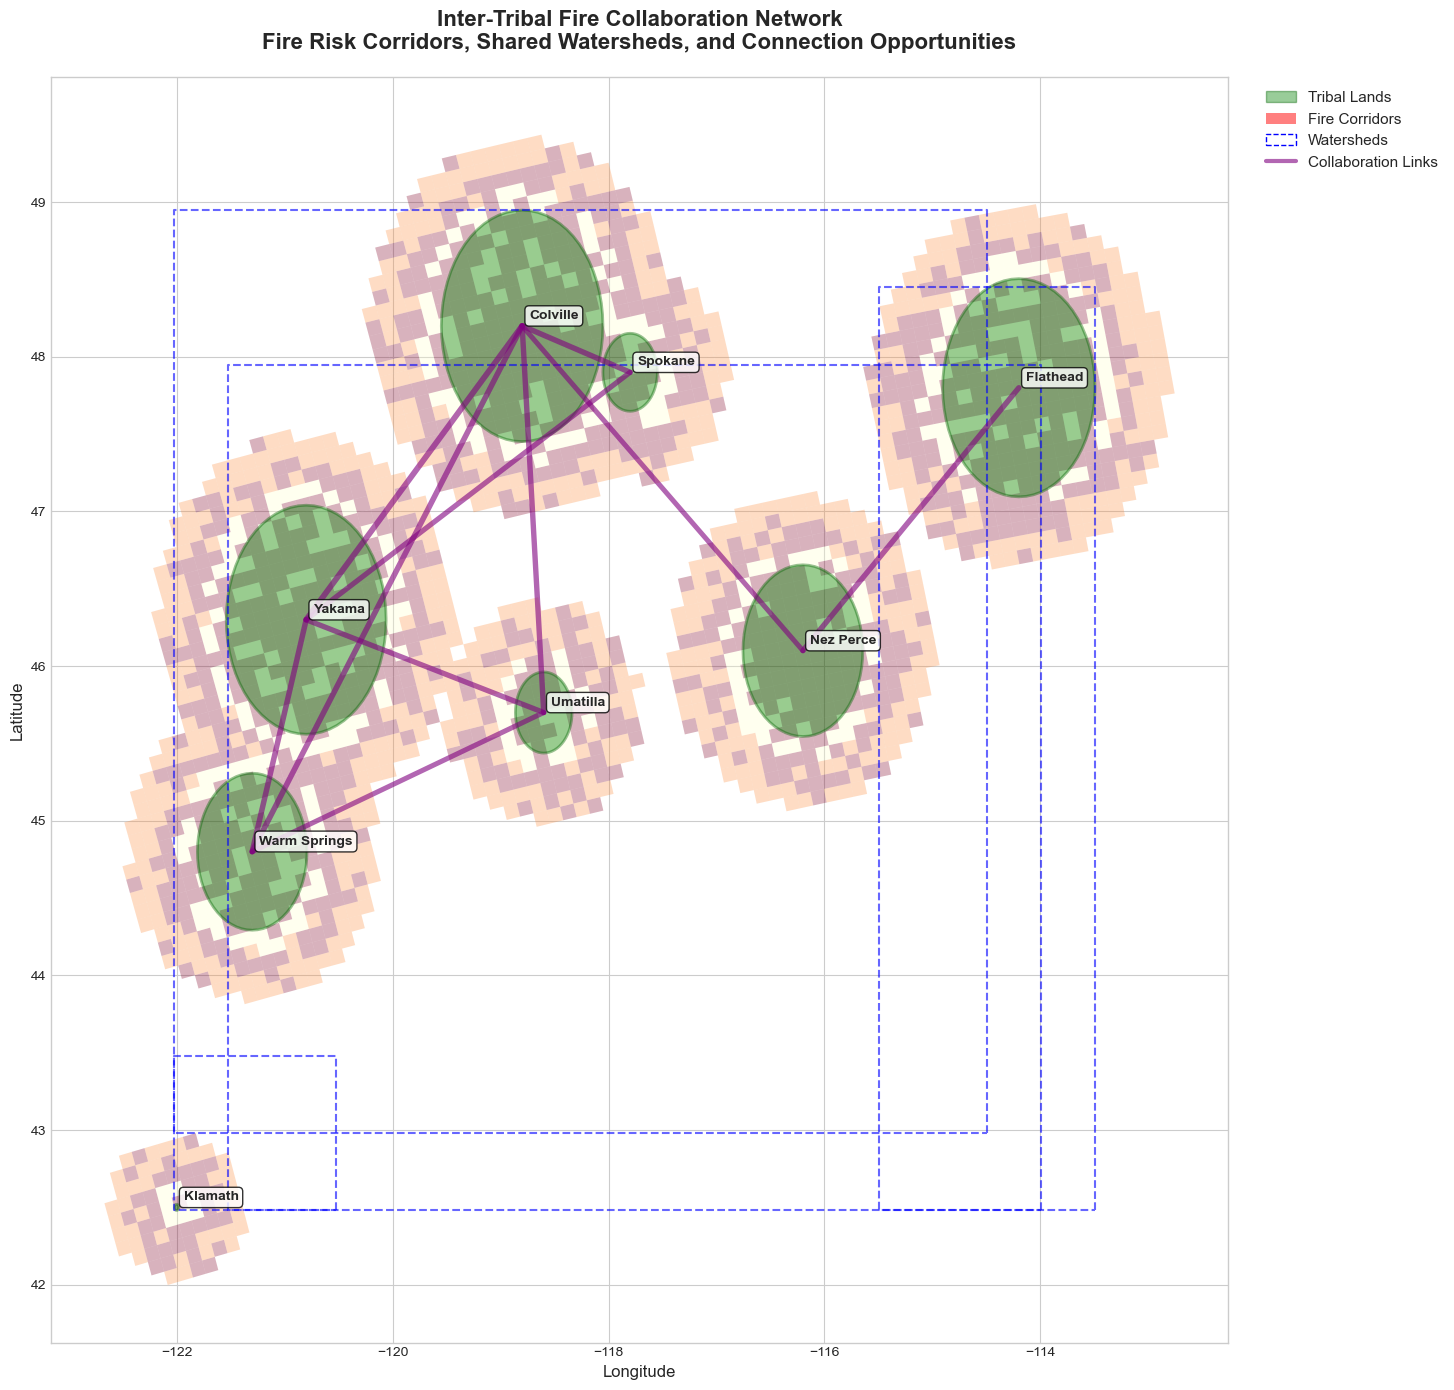


Regional map saved to: regional_collaboration_map.png


In [ ]:
# Create regional map
fig, ax = plt.subplots(figsize=(18, 14))

# Plot fire risk
fire_risk.plot(
    column='risk_category',
    categorical=True,
    legend=False,
    alpha=0.3,
    cmap='YlOrRd',
    ax=ax
)

# Plot watersheds
watersheds.boundary.plot(
    ax=ax,
    color='blue',
    linewidth=1.5,
    linestyle='--',
    alpha=0.6,
    label='Watersheds'
)

# Plot fire corridors
if len(fire_corridors) > 0:
    fire_corridors.plot(
        ax=ax,
        color='red',
        alpha=0.5,
        edgecolor='darkred',
        linewidth=2,
        label='High-Risk Fire Corridors'
    )

# Plot tribal lands
tribal_lands.plot(
    ax=ax,
    color='green',
    alpha=0.4,
    edgecolor='darkgreen',
    linewidth=2,
    label='Tribal Lands'
)

# Add tribal labels
for idx, tribe in tribal_lands.iterrows():
    ax.annotate(
        tribe['tribe_name'],
        xy=(tribe['lon'], tribe['lat']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
    )

# Draw connection lines
top_connections = collaboration_opportunities.head(10)
for idx, conn in top_connections.iterrows():
    tribe1_data = tribal_lands[tribal_lands['tribe_id'] == conn['tribe1_id']].iloc[0]
    tribe2_data = tribal_lands[tribal_lands['tribe_id'] == conn['tribe2_id']].iloc[0]
    
    # Line width based on opportunity score
    lw = conn['opportunity_score'] / 20
    
    ax.plot(
        [tribe1_data['lon'], tribe2_data['lon']],
        [tribe1_data['lat'], tribe2_data['lat']],
        color='purple',
        linewidth=lw,
        alpha=0.6,
        linestyle='-'
    )

ax.set_title(
    'Inter-Tribal Fire Collaboration Network\n'
    'Fire Risk Corridors, Shared Watersheds, and Connection Opportunities',
    fontsize=16,
    fontweight='bold',
    pad=20
)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Custom legend
legend_elements = [
    mpatches.Patch(facecolor='green', edgecolor='darkgreen', alpha=0.4, label='Tribal Lands'),
    mpatches.Patch(facecolor='red', alpha=0.5, label='Fire Corridors'),
    mpatches.Patch(facecolor='none', edgecolor='blue', linestyle='--', label='Watersheds'),
    plt.Line2D([0], [0], color='purple', linewidth=3, alpha=0.6, label='Collaboration Links')
]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=11)

plt.tight_layout()
plt.savefig('C:\Miniconda\Tribal_fire_science\output', dpi=300, bbox_inches='tight')
plt.show()

print("\nRegional map saved to: regional_collaboration_map.png")

### 6.2 Network Graph Visualization

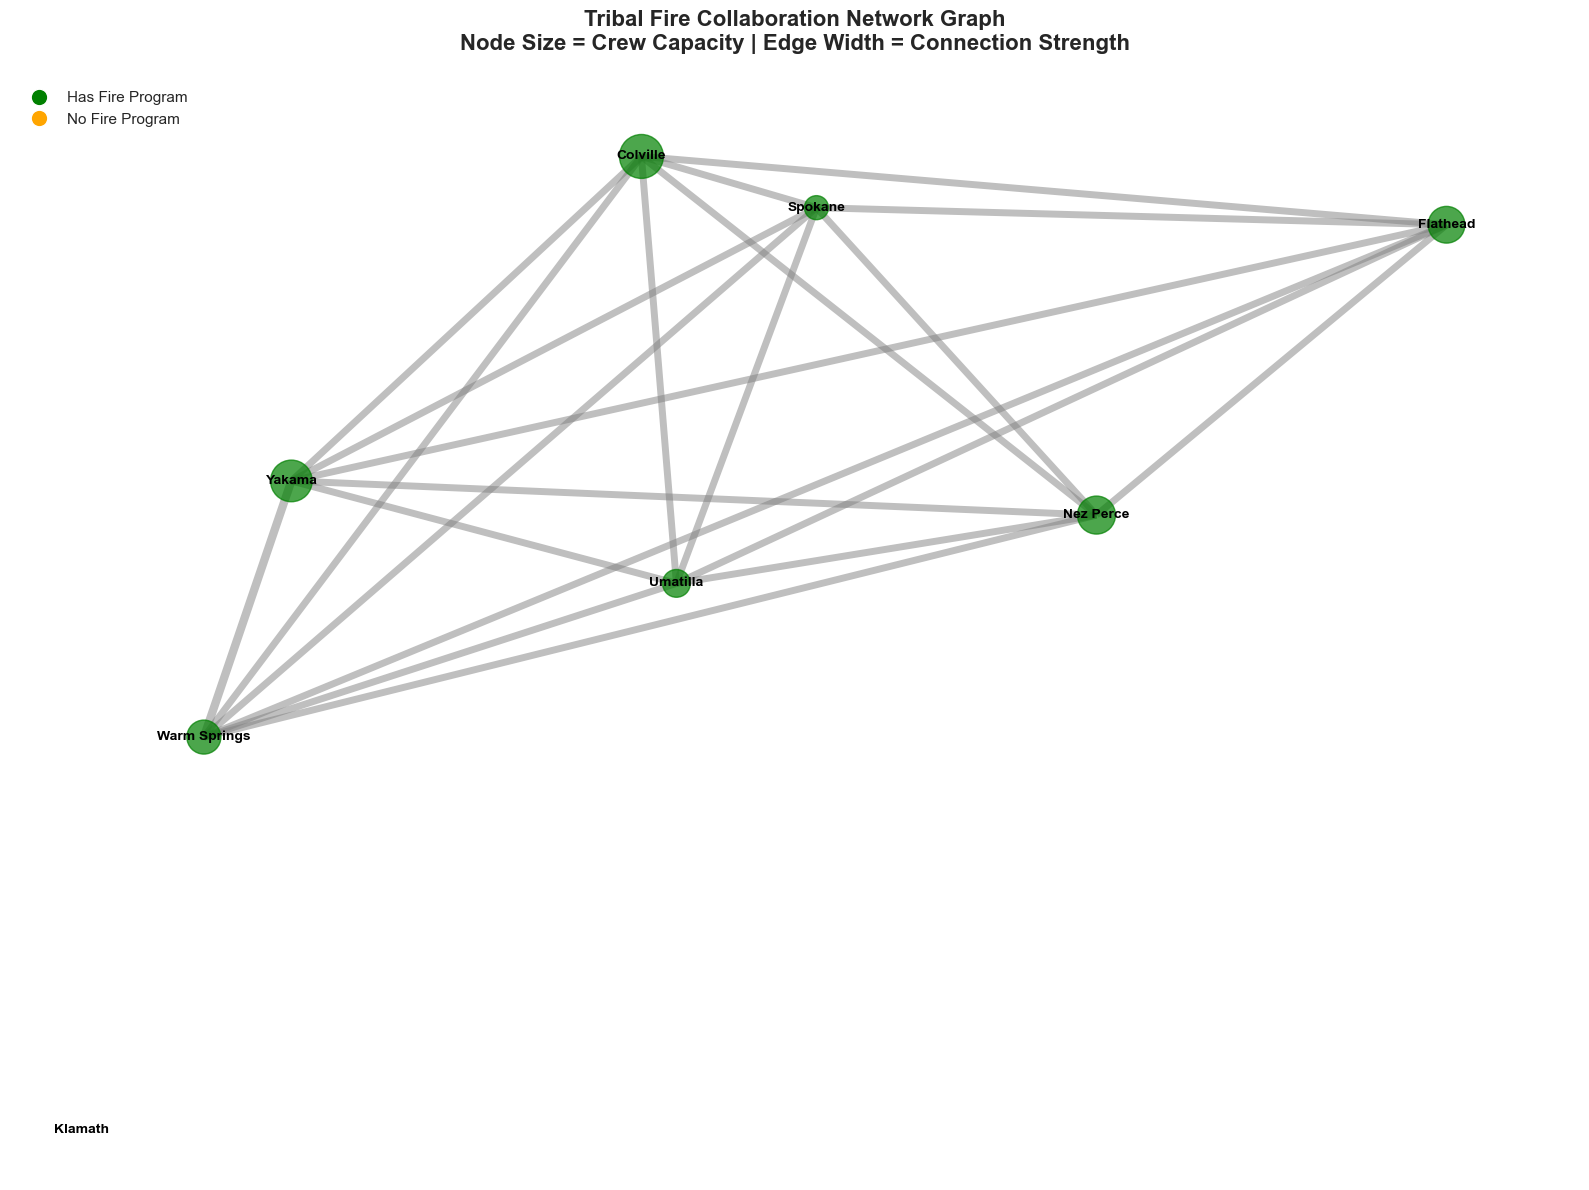


Network graph saved to: collaboration_network_graph.png


In [15]:
# Create network graph visualization
fig, ax = plt.subplots(figsize=(16, 12))

# Use geographic positions
pos = {node: (data['lon'], data['lat']) 
       for node, data in collaboration_network.nodes(data=True)}

# Node sizes based on crew size
node_sizes = [collaboration_network.nodes[node]['crew_size'] * 50 
              for node in collaboration_network.nodes()]

# Node colors based on whether they have fire program
node_colors = ['green' if collaboration_network.nodes[node]['fire_program'] 
              else 'orange' for node in collaboration_network.nodes()]

# Edge widths based on connection strength
edge_widths = [data.get('weight', 1) for _, _, data in collaboration_network.edges(data=True)]

# Draw network
nx.draw_networkx_nodes(
    collaboration_network,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.7,
    ax=ax
)

nx.draw_networkx_edges(
    collaboration_network,
    pos,
    width=edge_widths,
    alpha=0.5,
    edge_color='gray',
    ax=ax
)

# Labels
labels = {node: data['name'] 
         for node, data in collaboration_network.nodes(data=True)}
nx.draw_networkx_labels(
    collaboration_network,
    pos,
    labels,
    font_size=10,
    font_weight='bold',
    ax=ax
)

ax.set_title(
    'Tribal Fire Collaboration Network Graph\n'
    'Node Size = Crew Capacity | Edge Width = Connection Strength',
    fontsize=16,
    fontweight='bold',
    pad=20
)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
              markersize=12, label='Has Fire Program'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', 
              markersize=12, label='No Fire Program')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=11)

ax.axis('off')
plt.tight_layout()
plt.savefig('C:\Miniconda\Tribal_fire_science\output', dpi=300, bbox_inches='tight')
plt.show()

print("\nNetwork graph saved to: collaboration_network_graph.png")

### Collaboration Opportunity Matrix

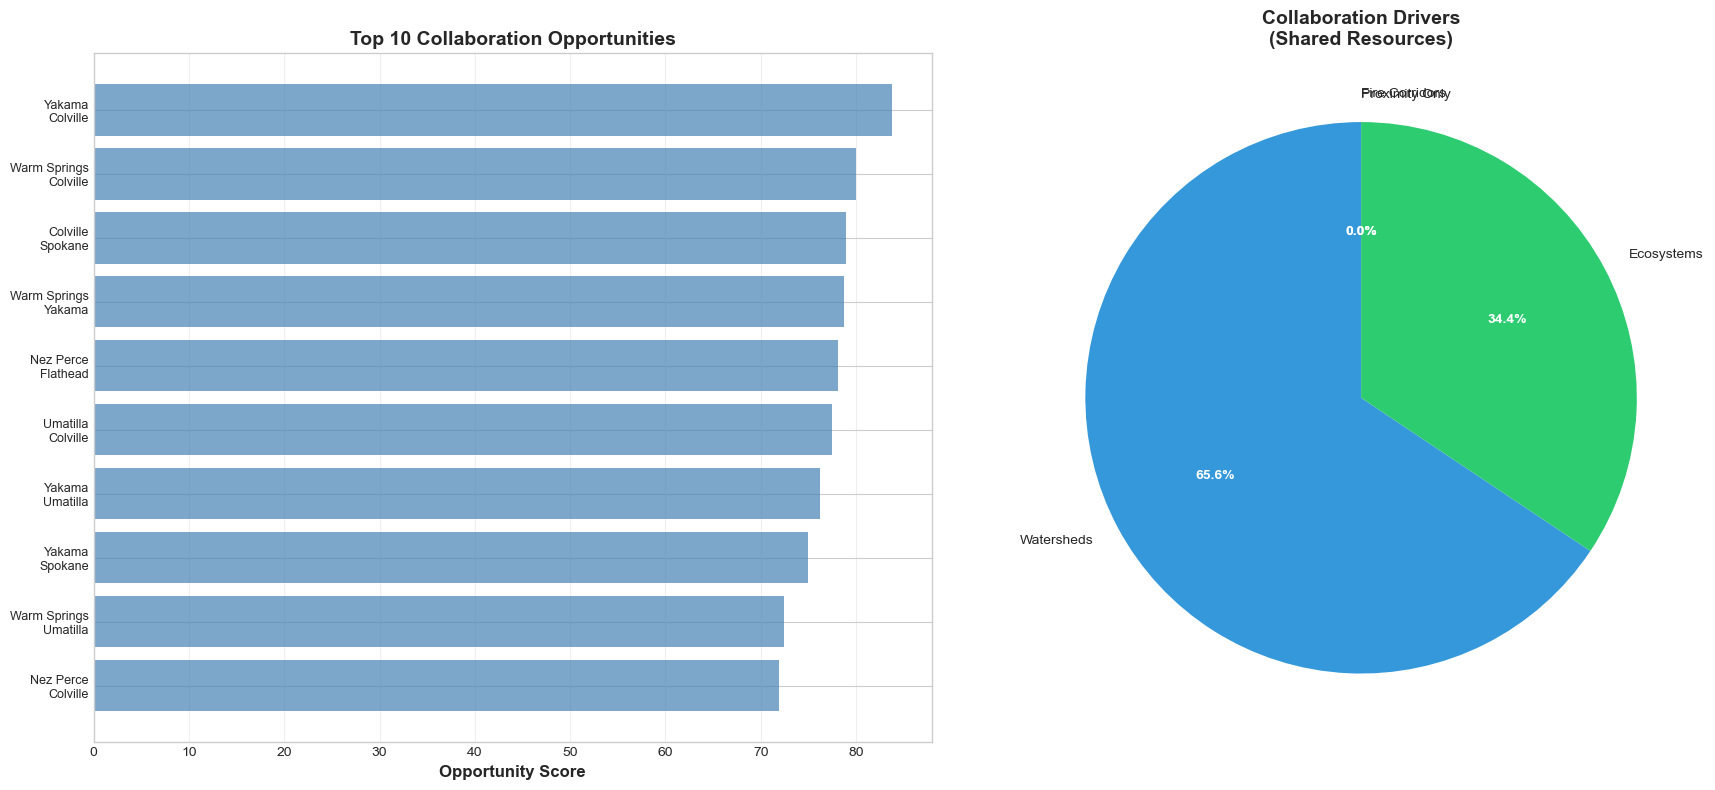


Opportunity analysis saved to: collaboration_opportunities.png


In [16]:
# Create opportunity matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Chart 1: Top collaboration pairs
top_10 = collaboration_opportunities.head(10)
labels = [f"{row['tribe1'][:15]}\n{row['tribe2'][:15]}" 
         for _, row in top_10.iterrows()]

y_pos = np.arange(len(labels))
ax1.barh(y_pos, top_10['opportunity_score'], color='steelblue', alpha=0.7)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(labels, fontsize=9)
ax1.set_xlabel('Opportunity Score', fontsize=12, fontweight='bold')
ax1.set_title('Top 10 Collaboration Opportunities', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# Chart 2: Connection type breakdown
connection_data = {
    'Fire Corridors': collaboration_opportunities['shared_corridors'].sum(),
    'Watersheds': collaboration_opportunities['shared_watersheds'].sum(),
    'Ecosystems': collaboration_opportunities['shared_ecosystems'].sum(),
    'Proximity Only': len(collaboration_opportunities[
        (collaboration_opportunities['shared_corridors'] == 0) &
        (collaboration_opportunities['shared_watersheds'] == 0) &
        (collaboration_opportunities['shared_ecosystems'] == 0)
    ])
}

colors = ['#e74c3c', '#3498db', '#2ecc71', '#95a5a6']
wedges, texts, autotexts = ax2.pie(
    connection_data.values(),
    labels=connection_data.keys(),
    autopct='%1.1f%%',
    colors=colors,
    startangle=90
)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax2.set_title('Collaboration Drivers\n(Shared Resources)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('C:\Miniconda\Tribal_fire_science\output', dpi=300, bbox_inches='tight')
plt.show()

print("\nOpportunity analysis saved to: collaboration_opportunities.png")

## Export Results

In [17]:
# Create output directory
import os
output_dir = 'C:\Miniconda\Tribal_fire_science\output'
os.makedirs(output_dir, exist_ok=True)

# Export spatial data
if len(fire_corridors) > 0:
    fire_corridors.to_file(
        f'{output_dir}/fire_corridors.geojson',
        driver='GeoJSON'
    )
    print(f"✓ {output_dir}/fire_corridors.geojson")

tribal_lands.to_file(
    f'{output_dir}/tribal_lands.geojson',
    driver='GeoJSON'
)
print(f"✓ {output_dir}/tribal_lands.geojson")

# Export tables
collaboration_opportunities.to_csv(
    f'{output_dir}/collaboration_opportunities.csv',
    index=False
)
print(f"✓ {output_dir}/collaboration_opportunities.csv")

centrality.to_csv(
    f'{output_dir}/network_centrality.csv',
    index=False
)
print(f"✓ {output_dir}/network_centrality.csv")

if len(shared_watersheds) > 0:
    shared_watersheds.to_csv(
        f'{output_dir}/shared_watersheds.csv',
        index=False
    )
    print(f"✓ {output_dir}/shared_watersheds.csv")

if len(shared_ecosystems) > 0:
    shared_ecosystems.to_csv(
        f'{output_dir}/shared_ecosystems.csv',
        index=False
    )
    print(f"✓ {output_dir}/shared_ecosystems.csv")

# Export network as edge list
edge_list = []
for edge in collaboration_network.edges(data=True):
    tribe1, tribe2, data = edge
    edge_list.append({
        'tribe1_id': tribe1,
        'tribe1_name': collaboration_network.nodes[tribe1]['name'],
        'tribe2_id': tribe2,
        'tribe2_name': collaboration_network.nodes[tribe2]['name'],
        'weight': data.get('weight', 1),
        'connection_type': data.get('connection_type', 'unknown'),
        'distance_km': data.get('distance_km', None)
    })

pd.DataFrame(edge_list).to_csv(
    f'{output_dir}/network_edges.csv',
    index=False
)
print(f"{output_dir}/network_edges.csv")

print("\n" + "="*80)
print("Outputs exported successfully")
print("="*80)

✓ C:\Miniconda\Tribal_fire_science\output/tribal_lands.geojson
✓ C:\Miniconda\Tribal_fire_science\output/collaboration_opportunities.csv
✓ C:\Miniconda\Tribal_fire_science\output/network_centrality.csv
✓ C:\Miniconda\Tribal_fire_science\output/shared_watersheds.csv
✓ C:\Miniconda\Tribal_fire_science\output/shared_ecosystems.csv
C:\Miniconda\Tribal_fire_science\output/network_edges.csv

Outputs exported successfully


## Generate Report

In [18]:
# Generate report
report = f"""
{'='*80}
CROSS-TRIBAL & REGIONAL FIRE COLLABORATION ANALYSIS
{'='*80}
Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Region: {tribal_lands['region'].mode()[0] if len(tribal_lands) > 0 else 'Multi-region'}

EXECUTIVE SUMMARY
{'='*80}

This analysis identifies opportunities for inter-tribal and regional fire
management collaboration. Fire doesn't respect boundaries, so effective fire
management requires coordinated action across jurisdictions.

STUDY AREA
{'='*80}
Tribal Reservations: {len(tribal_lands)}
Total Tribal Acres: {tribal_lands['acres'].sum():,}
States: {', '.join(tribal_lands['state'].unique())}
Regions: {', '.join(tribal_lands['region'].unique())}

FIRE MANAGEMENT CAPACITY
{'='*80}
Tribes with Fire Programs: {tribal_lands['fire_program'].sum()}
Total Crew Personnel: {tribal_lands['crew_size'].sum()}
Average Crew Size: {tribal_lands[tribal_lands['fire_program']]['crew_size'].mean():.1f}

FIRE RISK CORRIDORS
{'='*80}
High-Risk Corridors Identified: {len(fire_corridors)}
"""

if len(fire_corridors) > 0:
    report += f"Total Corridor Area: {fire_corridors['corridor_area_sqkm'].sum():,.0f} km²\n"
    report += f"Mean Risk Score: {fire_corridors['risk_score'].mean():.2f}/10\n"
    report += f"\nKey Corridors:\n"
    for idx, corridor in fire_corridors.nlargest(3, 'corridor_area_sqkm').iterrows():
        report += f"  • {corridor['connected_tribes']}\n"
        report += f"    Area: {corridor['corridor_area_sqkm']:.0f} km² | Risk: {corridor['risk_score']:.1f}/10\n"

report += f"""

SHARED WATERSHEDS
{'='*80}
Multi-Tribal Watersheds: {len(shared_watersheds)}
"""

if len(shared_watersheds) > 0:
    for idx, ws in shared_watersheds.iterrows():
        report += f"\n{ws['watershed_name']}:\n"
        report += f"  Tribes: {', '.join(ws['tribe_names'])}\n"
        report += f"  Tribal Coverage: {ws['pct_of_watershed']:.1f}% of watershed\n"

report += f"""

SHARED ECOSYSTEMS & FIRE REGIMES
{'='*80}
Multi-Tribal Ecosystems: {len(shared_ecosystems[shared_ecosystems['num_tribes'] >= 2])}
"""

if len(shared_ecosystems) > 0:
    for idx, eco in shared_ecosystems[shared_ecosystems['num_tribes'] >= 2].iterrows():
        report += f"\n{eco['ecosystem_name']} ({eco['ecosystem_type']}):\n"
        report += f"  Fire Regime: {eco['fire_regime']}\n"
        report += f"  Tribes: {', '.join(eco['tribe_names'])}\n"
        report += f"  Knowledge sharing opportunity\n"

report += f"""

COLLABORATION NETWORK ANALYSIS
{'='*80}
Network Nodes (Tribes): {collaboration_network.number_of_nodes()}
Network Edges (Connections): {collaboration_network.number_of_edges()}
Network Density: {nx.density(collaboration_network):.3f}
Average Connections per Tribe: {sum(dict(collaboration_network.degree()).values()) / collaboration_network.number_of_nodes():.1f}

Most Connected Tribes:
"""

for idx, row in centrality.head(3).iterrows():
    report += f"  • {row['tribe_name']}: {row['num_connections']} connections\n"

report += f"""

Bridge Tribes (connect different groups):
"""

bridges = centrality.nlargest(3, 'betweenness_centrality')
for idx, row in bridges.iterrows():
    report += f"  • {row['tribe_name']}: Critical for regional coordination\n"

report += f"""

COLLABORATION CLUSTERS
{'='*80}
Natural Collaboration Groups: {len(clusters)}
"""

for idx, cluster in clusters.iterrows():
    report += f"\nCluster {cluster['cluster_id']}:\n"
    report += f"  Tribes: {', '.join(cluster['tribes'])}\n"
    report += f"  Combined Capacity: {cluster['total_crew']} personnel\n"
    report += f"  Connections: {cluster['connections']}\n"

report += f"""

TOP COLLABORATION OPPORTUNITIES
{'='*80}
"""

for idx, opp in collaboration_opportunities.head(5).iterrows():
    report += f"\n{idx+1}. {opp['tribe1']} ↔ {opp['tribe2']}\n"
    report += f"   Opportunity Score: {opp['opportunity_score']:.1f}/100\n"
    report += f"   Combined Crew: {opp['combined_crew']} personnel\n"
    if opp['shared_corridors'] > 0:
        report += f"   Shared Fire Corridors: {opp['shared_corridors']}\n"
    if opp['shared_watersheds'] > 0:
        report += f"   Shared Watersheds: {opp['shared_watersheds']}\n"
    if opp['shared_ecosystems'] > 0:
        report += f"   Shared Ecosystems: {opp['shared_ecosystems']}\n"

report += f"""

RECOMMENDATIONS
{'='*80}

IMMEDIATE ACTIONS (Year 1):

1. ESTABLISH REGIONAL FIRE COUNCIL
   - Convene all Tribes in study area
   - Develop shared fire management agreements
   - Create resource sharing protocols
   - Meet quarterly during fire season

2. ADDRESS PRIORITY FIRE CORRIDORS
   - Focus on top 3 highest-risk corridors
   - Conduct coordinated fuel reduction
   - Develop mutual aid agreements
   - Pre-position resources

3. FORMALIZE TOP 5 COLLABORATIONS
   - Develop MOUs for highest-scoring pairs
   - Share crew training and resources
   - Conduct joint prescribed burns
   - Create shared communication systems

MEDIUM-TERM (Years 2-3):

4. WATERSHED-SCALE PLANNING
   - Develop coordinated fire plans for shared watersheds
   - Address water quality and supply protection
   - Coordinate post-fire restoration

5. ECOSYSTEM-BASED KNOWLEDGE SHARING
   - Tribes in similar fire regimes share best practices
   - Document traditional fire knowledge
   - Develop regime-specific training programs

6. BUILD COLLECTIVE CAPACITY
   - Pool resources for equipment purchases
   - Shared training programs
   - Regional crew coordination
   - Combined political advocacy

LONG-TERM (Years 4-5):

7. ESTABLISH REGIONAL FIRE CENTER
   - Centralized dispatch and coordination
   - Shared equipment cache
   - Training facility
   - Emergency operations center

8. DEVELOP COLLECTIVE BARGAINING POWER
   - Joint federal funding requests
   - Shared contracts for services
   - Regional policy advocacy
   - Multi-tribal voice in fire policy

BARRIERS TO ADDRESS:

• Jurisdictional complexity and sovereignty concerns
• Limited funding for coordination
• Different organizational structures
• Historical inter-tribal tensions
• Lack of existing frameworks
• Federal/state coordination challenges

COMMUNICATE:

• Shared fire risk and common challenges
• Existing tribal networks and relationships
• Federal emphasis on Tribal coordination
• Climate change urgency
• Successful models from other regions
• Growing recognition of Indigenous fire stewardship

OUTPUT FILES
{'='*80}

Spatial Data:
  - fire_corridors.geojson
  - tribal_lands.geojson

Analysis Tables:
  - collaboration_opportunities.csv
  - network_centrality.csv
  - shared_watersheds.csv
  - shared_ecosystems.csv
  - network_edges.csv

Maps & Figures:
  - regional_collaboration_map.png
  - collaboration_network_graph.png
  - collaboration_opportunities.png

CONCLUSION
{'='*80}

This analysis demonstrates that significant opportunities exist for inter-tribal
and regional fire collaboration. Shared fire risk corridors, watersheds, and
ecosystems create natural foundations for cooperation.

By working together, tribes can:
  • Increase fire management capacity
  • Share scarce resources more efficiently
  • Amplify political voice and influence
  • Protect shared landscapes more effectively
  • Build collective resilience to climate change

The network analysis identifies both natural clusters and strategic bridges.
Priority should be given to high-opportunity collaborations that address
critical fire corridors while building on existing relationships.

Fire doesn't respect boundaries. Neither should our response to it.

{'='*80}
END OF REPORT
{'='*80}
"""

# Save report
report_path = f'{output_dir}/Regional_Collaboration_Report.txt'
with open(report_path, 'w') as f:
    f.write(report)

print(f"\nReport saved to: {report_path}")
print("\n" + report)


Report saved to: C:\Miniconda\Tribal_fire_science\output/Regional_Collaboration_Report.txt


CROSS-TRIBAL & REGIONAL FIRE COLLABORATION ANALYSIS
Report Generated: 2026-02-16 14:39
Region: Pacific Northwest

EXECUTIVE SUMMARY

This analysis identifies opportunities for inter-tribal and regional fire
management collaboration. Fire doesn't respect boundaries, so effective fire
management requires coordinated action across jurisdictions.

STUDY AREA
Tribal Reservations: 8
Total Tribal Acres: 5,761,000
States: OR, WA, ID, MT
Regions: Pacific Northwest, Northern Rockies

FIRE MANAGEMENT CAPACITY
Tribes with Fire Programs: 7
Total Crew Personnel: 93
Average Crew Size: 13.3

FIRE RISK CORRIDORS
High-Risk Corridors Identified: 0


SHARED WATERSHEDS
Multi-Tribal Watersheds: 2

Columbia River Basin - Upper:
  Tribes: Warm Springs, Yakama, Umatilla, Nez Perce, Colville, Flathead, Spokane
  Tribal Coverage: 410.6% of watershed

Columbia River Basin - Middle:
  Tribes: Warm Springs, Yakama, Umatill